## Replication code for
# Carbon Taxes vs. Green Subsidies: Generational Conflicts and Distributional Consequences
### Gregor Boehl and Flora Budianto

First, install the necessary packages. Do this either here (uncomment the cell below) or with your prefered package manager.

In [1]:
#!pip install econpizza
#!pip install grgrlib
#!pip mpl_axes_aligner

The documentation for the EP package, which is used for the simulations in the paper, can be found [here](https://econpizza.readthedocs.io/en/stable/index.html).

Do some imports:

In [2]:
# imports
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import econpizza as ep
from grgrlib import * 
from mpl_axes_aligner import align

# plotting setup
plt.rc('text', usetex=True)

# if you run this in a jupyter notebook:
%matplotlib inline

The YAML file which contains the HANK model with energy sector is hosted as part of the example models for EP: https://github.com/gboehl/econpizza/blob/master/econpizza/examples/hank_climate.yml

All the models from the paper, and some others, are included: https://github.com/gboehl/econpizza/tree/master/econpizza/examples

That means, if you are on econpizza version 0.6.8 and above, the model for this exercise is included in the examples. You can simply do:

In [3]:
path_yaml = ep.examples.hank_climate

If you are on econpizza version 0.6.7 and below, you have to take the rocky road:

In [4]:
import requests
import tempfile
import os

url_yaml = "https://raw.githubusercontent.com/gboehl/econpizza/refs/heads/master/econpizza/examples/hank_climate.yml"
url_funcs = "https://raw.githubusercontent.com/gboehl/econpizza/refs/heads/master/econpizza/examples/hank_climate_functions.py"

# download yaml
dl_yaml = requests.get(url_yaml)
dl_funcs = requests.get(url_funcs)

# write content to temporary directory
tmpdir = tempfile.TemporaryDirectory()
tmpdirname = tmpdir.name

path_yaml = os.path.join(tmpdirname, 'hank_climate.yaml')
path_funcs = os.path.join(tmpdirname, 'hank_climate_functions.py')

with open(path_yaml, 'wb') as f:
    f.write(dl_yaml.content)

with open(path_funcs, 'wb') as f:
    f.write(dl_funcs.content)

Either way, continue here:

In [5]:
# parse the model
mod_dict = ep.parse(path_yaml)

# production values, meaning a large grid
mod_dict['globals']['a_n'] = 200
mod_dict['globals']['a_max'] = 300

In [6]:
# load model and solve for steady state
mod = ep.load(mod_dict, raise_errors=True)
res_stst = mod.solve_stst(tol=1e-8, tol_forwards=1e-12, maxit=25, relaxation=1)

Creating grid variables:
    ...adding exogenous Rouwenhorst-grid for 'skills' with objects 'skills_grid', 'skills_transition' and 'skills_stationary'.
    ...expecting the object 'a_grid' for the endogenous grid of 'a'.
(load:) Parsing done.
    Iteration   1 | max. error 6.48e+00 | lapsed 3.1879
    Iteration   2 | max. error 2.01e+00 | lapsed 4.9018
    Iteration   3 | max. error 5.03e-01 | lapsed 6.6663
    Iteration   4 | max. error 6.19e-02 | lapsed 8.3698
    Iteration   5 | max. error 1.32e-03 | lapsed 10.0492
    Iteration   6 | max. error 6.30e-07 | lapsed 11.6833
(solve_stst:) Steady state found (13.594s). The solution converged.


In [7]:
# rearrange the model dict to express the model in paramters only
mod_dict['steady_state']['fixed_values']['BR'] = mod.stst['BR']
mod_dict['steady_state']['fixed_values']['AGR'] = mod.pars['AGR']
mod_dict['steady_state']['fixed_values']['zRND'] = mod.pars['zRND']
mod_dict['steady_state']['fixed_values']['z'] = mod.stst['z']
mod_dict['steady_state']['init_guesses']['g2y'] = mod.pars['g2y']
mod_dict['steady_state']['fixed_values']['g'] = mod.stst['g']
del mod_dict['steady_state']['fixed_values']['g2y']
del mod_dict['steady_state']['fixed_values']['BR2E']
del mod_dict['steady_state']['fixed_values']['y']
del mod_dict['steady_state']['fixed_values']['Am']

In [8]:
# split in two different models for the two policies
mod_dict_qbr = ep.deepcopy(mod_dict)
mod_dict_qgr = ep.deepcopy(mod_dict)

mod_dict_qbr['steady_state']['init_guesses']['tau_qBR'] = mod_dict_qbr['steady_state']['fixed_values']['tau_qBR']
mod_dict_qgr['steady_state']['init_guesses']['tau_qGR'] = mod_dict_qgr['steady_state']['fixed_values']['tau_qGR']
del mod_dict_qbr['steady_state']['fixed_values']['tau_qBR']
del mod_dict_qgr['steady_state']['fixed_values']['tau_qGR']

In [9]:
# require a reduction of carbon output by 50%
reduction = 0.5

In [10]:
# calculate steady state for tax model
mod_qbr, _ = ep.tools.anneal_stst(mod_dict_qbr, ('steady_state', 'fixed_values', 'BR'), mod.stst['BR']*(1-reduction), tol=1e-8, tol_forwards=1e-11, maxit=15, max_sequence=20)

(anneal_stst:) 1 value(s) in queue. Trying BR=0.4549353112165853...
    Iteration   1 | max. error 3.13e+00 | lapsed 3.2857
    Iteration   2 | max. error 1.72e+00 | lapsed 5.3835
    Iteration   3 | max. error 4.78e-01 | lapsed 7.2691
    Iteration   4 | max. error 8.75e-02 | lapsed 9.0018
    Iteration   5 | max. error 5.66e-03 | lapsed 10.7155
    Iteration   6 | max. error 3.17e-05 | lapsed 12.4661
(solve_stst:) Steady state found (14.3s). The solution converged.
(anneal_stst:) Success! Values are:

        Am: 2.0340570856652405
        BR2E: 0.2921624442750476
        C: 0.6060572216148036
        div: 0.20604559766257702
        divRND: 0.01709640674747383
        e: 1.5571313840348515
        GR: 1.1021960739350425
        i: 0.17494451602277752
        k: 6.997780640911102
        kBR: 0.20696613739173134
        kGR: 0.8727188300886733
        ky: 5.918095674504696
        n: 0.8762517649545152
        pricing_f: 7.96624608359834
        pricing_s: 7.96624608359834
        qB

In [11]:
# calculate steady state for subsidy model
mod_qgr, _ = ep.tools.anneal_stst(mod_dict_qgr, ('steady_state', 'fixed_values', 'BR'), mod.stst['BR']*(1-reduction), tol=1e-8, tol_forwards=1e-11, maxit=15, max_sequence=20)

(anneal_stst:) 1 value(s) in queue. Trying BR=0.4549353112165853...
    Iteration   1 | max. error 3.13e+00 | lapsed 3.3051
    Iteration   2 | max. error 3.53e+00 | lapsed 5.0861
    Iteration   3 | max. error 4.11e-01 | lapsed 6.7744
    Iteration   4 | max. error 5.39e-02 | lapsed 8.4670
    Iteration   5 | max. error 3.47e-04 | lapsed 10.2122
    Iteration   6 | max. error 3.02e-07 | lapsed 11.9130
(solve_stst:) Steady state found (13.668s). The solution converged.
(anneal_stst:) Success! Values are:

        Am: 4.379454401212591
        BR2E: 0.14175823369266047
        C: 0.6586228176550092
        div: 0.2281337379057634
        divRND: 0.01627528595767377
        e: 3.209233773354869
        GR: 2.7542984621382836
        i: 0.22693619733580814
        k: 9.077447893432327
        kBR: 0.20696613739173134
        kGR: 1.8625116818903242
        ky: 7.007970074150273
        n: 0.9048893349948621
        pricing_f: 7.745111426293026
        pricing_s: 7.745111426293026
        

In [12]:
print('Level of cabon tax: ', jnp.log(mod_qbr.stst['tau_qBR']))
print('Level of green subsidy: ', jnp.log(mod_qgr.stst['tau_qGR']))

Level of cabon tax:  0.7404671840150431
Level of green subsidy:  -0.3272377079619153


In [13]:
# setup to simulate transitions
init_stst = mod['stst'].copy()
init_dist = mod['steady_state']['distributions']

horizon = 400

In [14]:
# simulate tax model transition
xst_qbr, flags = mod_qbr.find_path(init_state=init_stst.values(), init_dist=init_dist, horizon=horizon, tol=1e-8)

(get_derivatives:) Derivatives calculation done (8.419s).
(get_jacobian:) Jacobian accumulation and decomposition done (22.117s).
    Iteration  1 | fev.  12 | error 1.18e+00 | inner 4.42e-06 | dampening 1.000
    Iteration  2 | fev.  24 | error 3.22e-01 | inner 4.58e-06 | dampening 1.000
    Iteration  3 | fev.  36 | error 8.54e-02 | inner 7.19e-06 | dampening 1.000
    Iteration  4 | fev.  41 | error 3.15e-03 | inner 8.49e-06 | dampening 1.000
    Iteration  5 | fev.  45 | error 4.72e-06 | inner 4.39e-07 | dampening 1.000
    Iteration  6 | fev.  49 | error 2.42e-07 | inner 2.25e-08 | dampening 1.000
    Iteration  7 | fev.  79 | error 1.25e-08 | inner 7.88e-08 | dampening 0.912
    Iteration  8 | fev.  84 | error 7.57e-08 | inner 5.44e-09 | dampening 0.697
    Iteration  9 | fev.  89 | error 2.72e-09 | inner 1.96e-10 | dampening 0.697 | lapsed 41.5497s
(find_path:) Stacking done (72.305s). The solution converged.


In [15]:
# simulate subsidy model transition
xst_qgr, flags = mod_qgr.find_path(init_state=init_stst.values(), init_dist=init_dist, horizon=horizon, tol=1e-8, relaxation=.2, maxit=300)

(get_derivatives:) Derivatives calculation done (3.899s).
(get_jacobian:) Jacobian accumulation and decomposition done (21.662s).
    Iteration  1 | fev.  18 | error 2.63e+00 | inner 9.08e-06 | dampening 1.000
    Iteration  2 | fev.  48 | error 1.99e+00 | inner 7.83e-05 | dampening 1.000
    Iteration  3 | fev.  78 | error 1.58e+00 | inner 2.50e-02 | dampening 1.000
    Iteration  4 | fev. 108 | error 1.31e+00 | inner 2.55e-02 | dampening 1.000
    Iteration  5 | fev. 138 | error 9.94e-01 | inner 3.13e-05 | dampening 1.000
    Iteration  6 | fev. 168 | error 7.73e-01 | inner 2.38e+00 | dampening 1.000
    Iteration  7 | fev. 198 | error 1.16e+00 | inner 1.14e+01 | dampening 0.880
    Iteration  8 | fev. 228 | error 3.60e+00 | inner 4.98e+01 | dampening 0.281
    Iteration  9 | fev. 258 | error 2.11e+00 | inner 7.88e+00 | dampening 0.640
    Iteration 10 | fev. 288 | error 1.82e+00 | inner 4.92e-01 | dampening 0.346
    Iteration 11 | fev. 318 | error 1.37e+00 | inner 3.53e-01 | dampen

## Figure 2

In [16]:
# plotting setup
xstst_ini = jnp.ones_like(xst_qbr)*ep.parser.d2jnp(init_stst)
xstst_qbr = jnp.ones_like(xst_qbr)*ep.parser.d2jnp(mod_qbr.stst)
xstst_qgr = jnp.ones_like(xst_qgr)*ep.parser.d2jnp(mod_qgr.stst)

# variable choice
choice = {
          'qe': 'energy prices',
          'qBR': 'brown energy prices',
          'qGR': 'green energy prices',
          'e': 'total energy',
            #
          'y': 'output',
          'C': 'consumption',
          'pi': 'inflation',
          'Rr': 'real interest rate',
            #
          'BR': 'brown energy',
          'GR': 'green energy',
          's': r'R\&D investment',
          'Am': r'green R\&D',
            #
          'k': 'total capital',
          'ky': 'capital: final good',
          'kBR': 'capital: brown energy',
          'kGR': 'capital: green energy',
            #
          'n': 'labor',
          'w': 'wages',
          'rk': 'rental rate of capital',
          'tax': 'lump-sum taxes',
          }

# more setup
labels = None, 'carbon tax', 'green subsidy', None, None
inds = [mod.var_names.index(c) for c in list(choice.keys())]
plot_horizon = 250

In [17]:
# define function for variable transformations
def transform(x):
    x = x[:plot_horizon,inds]
    xss = xstst_ini[:plot_horizon,inds]
    x /= xss
    x = x.at[:,6].multiply(xss[:,6])
    x = x.at[:,6].power(4)
    x = x.at[:,7].multiply(xss[:,7])
    x = x.at[:,7].power(4)
    x = x.at[:,-2].set((1+x[:,-2]*xss[:,-2])**4)
    x -= 1
    x *= 100
    return x

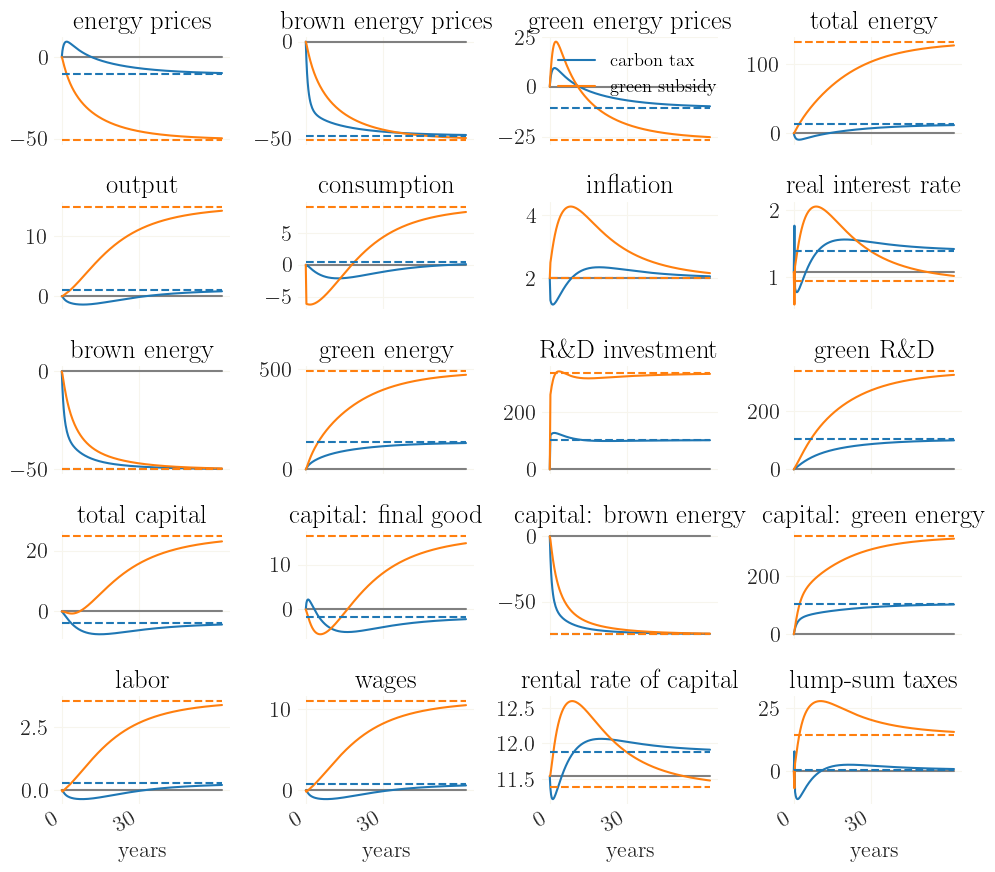

In [18]:
figs, axs = figurator(5,4, figsize=(10,9))
pplot((transform(xstst_ini), transform(xst_qbr), transform(xst_qgr), transform(xstst_qbr), transform(xstst_qgr)),
      xscale=jnp.arange(plot_horizon)/4,
      styles=('-', '-', '-', '--', '--'), colors=('gray', 'C0', 'C1', 'C0', 'C1'), ax=axs, labels=list(choice.values()), legend=labels)
axs[2].legend(framealpha=0)
[ax.set_xlabel('years') for ax in axs[-4:]]
[ax.set_xticks((0,30)) for ax in axs]
figs[0].tight_layout()

## Figure 3

In [19]:
# get values to calculate welfare
a_grid = mod['context']['a_grid']
e_stat = mod['context']['skills_grid']
het_qgr = mod_qgr.get_distributions(xst_qgr, init_dist=init_dist)
het_qbr = mod_qbr.get_distributions(xst_qbr, init_dist=init_dist)
values_stst_ini = mod['steady_state']['value_functions'][0]

tolifetime = lambda V: ((1-mod.stst['beta'])*(1-mod.pars['sigma_c'])*V)**(1/(1-mod.pars['sigma_c']))
interpolate_numpy = jnp.vectorize(jnp.interp, signature='(nq),(n),(n)->(nq)')
xs = jnp.linspace(0,1,4)

# for climate tax
values_qgr = het_qgr['VPrime']
dists_qgr = het_qgr['dist']
binned_weight_qgr = dists_qgr.sum(0).cumsum(0)
binned_values_qgr = (dists_qgr*tolifetime(values_qgr)).sum(0).cumsum(0)
bins_aggr_qgr = interpolate_numpy(xs[1:], binned_weight_qgr.T, binned_values_qgr.T)
welf_aggr_qgr = (dists_qgr*values_qgr).sum((0,1))
min_values_qgr = jnp.min(values_qgr, (0,1))

# for green subsidy
values_qbr = het_qbr['VPrime']
dists_qbr = het_qbr['dist']
binned_weight_qbr = dists_qbr.sum(0).cumsum(0)
binned_values_qbr = (dists_qbr*tolifetime(values_qbr)).sum(0).cumsum(0)
bins_aggr_qbr = interpolate_numpy(xs[1:], binned_weight_qbr.T, binned_values_qbr.T)
welf_aggr_qbr = (dists_qbr*values_qbr).sum((0,1))
min_values_qbr = jnp.min(values_qbr, (0,1))

ref_util = jnp.sum(values_stst_ini*init_dist)
ref_mima = jnp.min(values_stst_ini)

In [20]:
# get values to calculate CEVs
a_grid = mod['context']['a_grid']
e_stat = mod['context']['skills_stationary']
dist = init_dist[0]
bins = jnp.linspace(0,1,10)

# calculate consumption equivalent variation per CDF for now
cev = 100*((values_qgr[...,0]/values_stst_ini)**(1/(1-mod.pars['sigma_c'])) - 1)
cev_a = jnp.sum(cev*e_stat[:,None], 0)
dist_a = jnp.sum(dist, 0)
cev_in_bins_qgr = jnp.diff(jnp.interp(bins[1:], dist_a.cumsum(), (dist_a*cev_a).cumsum()), prepend=0)*10

cev = 100*((values_qbr[...,0]/values_stst_ini)**(1/(1-mod.pars['sigma_c'])) - 1)
cev_a = jnp.sum(cev*e_stat[:,None], 0)
dist_a = jnp.sum(dist, 0)
cev_in_bins_qbr = jnp.diff(jnp.interp(bins[1:], dist_a.cumsum(), (dist_a*cev_a).cumsum()), prepend=0)*10

# calculate consumption equivalent variation per CDF for then
cev = 100*((values_qgr[...,30*4]/values_stst_ini)**(1/(1-mod.pars['sigma_c'])) - 1)
cev_a = jnp.sum(cev*e_stat[:,None], 0)
dist_a = jnp.sum(dist, 0)
dist_a_then = jnp.sum(dists_qgr[...,30*4], 0)
cev_in_bins_qgr_then = jnp.diff(jnp.interp(bins[1:], dist_a_then.cumsum(), (dist_a_then*cev_a).cumsum()), prepend=0)*10

cev = 100*((values_qbr[...,30*4]/values_stst_ini)**(1/(1-mod.pars['sigma_c'])) - 1)
cev_a = jnp.sum(cev*e_stat[:,None], 0)
dist_a = jnp.sum(dist, 0)
dist_a_then = jnp.sum(dists_qbr[...,30*4], 0)
cev_in_bins_qbr_then = jnp.diff(jnp.interp(bins[1:], dist_a_then.cumsum(), (dist_a*cev_a).cumsum()), prepend=0)*10

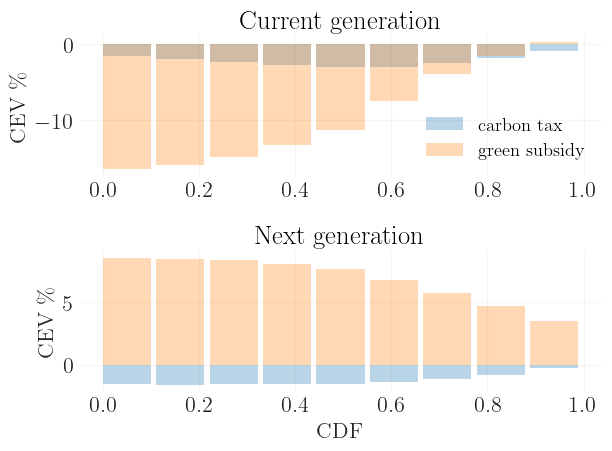

In [21]:
# plot difference in utilities
fig, axs = plt.subplots(2)
axs[0].bar(bins[:-1], cev_in_bins_qbr, width=0.1, alpha=0.3, align='edge', label='carbon tax')
axs[0].bar(bins[:-1], cev_in_bins_qgr, width=0.1, alpha=0.3, align='edge', label='green subsidy')
axs[0].set_ylabel('CEV \\%')
axs[1].bar(bins[:-1], cev_in_bins_qbr_then, width=0.1, alpha=0.3, align='edge', label='carbon tax')
axs[1].bar(bins[:-1], cev_in_bins_qgr_then, width=0.1, alpha=0.3, align='edge', label='green subsidy')
axs[1].set_xlabel('CDF')
axs[1].set_ylabel('CEV \\%')
axs[0].legend(framealpha=0)
axs[0].set_title('Current generation')
axs[1].set_title('Next generation')
fig.tight_layout()

## Figure 4

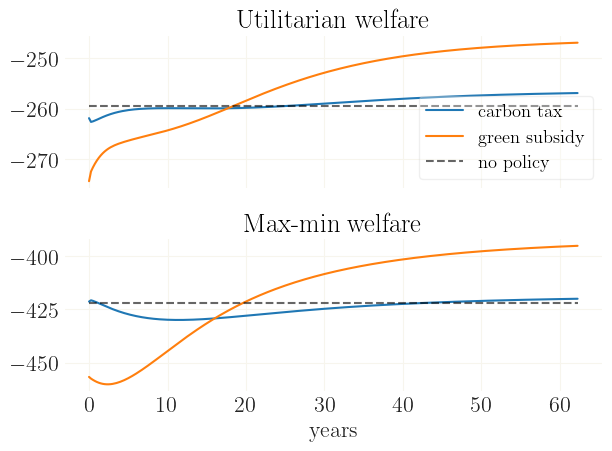

In [22]:
# plotting
fig, axs = plt.subplots(2, sharex=True)
axs[0].set_title('Utilitarian welfare')
axs[0].plot(jnp.arange(plot_horizon)/4, welf_aggr_qbr[:plot_horizon], label='carbon tax')
axs[0].plot(jnp.arange(plot_horizon)/4, welf_aggr_qgr[:plot_horizon], label='green subsidy')
axs[0].plot(jnp.arange(plot_horizon)/4, jnp.ones(plot_horizon)*ref_util, label='no policy', c='k', ls='--', alpha=.6)
axs[1].set_title('Max-min welfare')
axs[1].plot(jnp.arange(plot_horizon)/4, min_values_qbr[:plot_horizon], label='carbon tax')
axs[1].plot(jnp.arange(plot_horizon)/4, min_values_qgr[:plot_horizon], label='green subsidy')
axs[1].plot(jnp.arange(plot_horizon)/4, jnp.ones(plot_horizon)*ref_mima, label='no policy', c='k', ls='--', alpha=.6)
axs[1].set_xlabel('years')
axs[0].legend(framealpha=.3)
fig.tight_layout()